In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Activation
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from sklearn.utils import resample
from keras.optimizers import Adam, RMSprop
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from keras.activations import relu, sigmoid
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_recall_curve
from keras.utils import plot_model

Using TensorFlow backend.
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type

In [2]:
df1 = pd.read_csv("csv_result-Descriptors_Training.csv") 
df2 = pd.read_csv("csv_result-Descriptors_Calibration.csv") 
df1.head()

,id,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
0,1,5.59,14.91,13.69,6.45,12.11,28.79,32.40,0.06,0.09,...,0.69,23.12,0.64,0.76,-0.79,0.68,0.54,0.02,0.59,P
1,2,4.81,16.87,6.58,11.59,17.25,40.40,56.59,0.04,0.06,...,1.32,2.34,0.52,0.49,-1.27,1.39,-0.11,0.02,0.62,P
2,3,5.36,13.81,8.25,8.77,14.82,32.42,61.74,0.03,0.06,...,-0.69,-2.24,0.37,0.47,-0.74,2.03,0.58,0.01,0.56,P
3,4,6.10,73.66,6.41,11.14,37.36,38.26,55.93,0.04,0.19,...,1.50,2.44,0.40,0.44,-0.28,0.43,0.77,0.02,0.65,P
4,5,-2.00,16.41,8.51,7.07,30.95,50.22,39.52,0.05,0.05,...,1.88,7.72,0.42,0.50,-1.12,0.91,0.71,0.01,0.65,P


In [3]:
#data normalized
column_name = list(df1)[1:-1]
d = []
for i in column_name:
    df1[i] = (df1[i] - df1[i].mean())/df1[i].std() #Training set normalization
    df2[i] = (df2[i] - df2[i].mean())/df2[i].std() #Testing set normalization
    b = df1[df1[i].abs()>3]['id']
    d.append(list(b-1))
d = list(set(sum(d,[])))
df1 = df1.drop(df1.index[d])
df1.head()

,id,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
0,1,-0.117497,-0.367830,-0.087303,-0.242726,-0.435932,-0.476474,-0.439963,-0.052082,0.726030,...,0.029047,0.256825,0.011965,0.033127,-0.235917,-0.948452,0.000127,0.038128,0.038214,P
1,2,-0.314450,-0.324882,-0.230731,-0.148174,-0.313895,-0.375312,-0.229373,-0.577851,-0.065010,...,0.031275,-0.035155,0.010765,0.032294,-1.081833,0.647903,-2.255706,0.038128,0.038293,P
2,3,-0.175573,-0.391934,-0.197043,-0.200049,-0.371589,-0.444845,-0.184538,-0.840735,-0.065010,...,0.024167,-0.099509,0.009265,0.032232,-0.147801,2.086871,0.138947,0.038102,0.038135,P
4,5,-2.034000,-0.334961,-0.191798,-0.231321,0.011381,-0.289747,-0.377979,-0.314967,-0.328689,...,0.033255,0.040439,0.009765,0.032324,-0.817485,-0.431323,0.590114,0.038102,0.038371,P
5,6,1.586903,-0.335181,-0.202691,-0.219732,0.064327,-0.454081,-0.454676,-0.314967,0.198670,...,0.029436,0.171114,0.011565,0.032757,-0.817485,0.670387,-1.804539,0.038102,0.038030,P


In [4]:
df1['class'].value_counts()

N    16202
P      905
Name: class, dtype: int64

In [5]:
#upsampling
df_sort = df1.sort_values(by = 'class', ascending = False) #Put positive data in the first 1042 rows
X_minor = df_sort.iloc[:905,:]
X_major = df_sort.iloc[905:,:]
df_minority_upsampled = resample(X_minor, 
                                 replace=True, # sample with replacement
                                 n_samples=16202, # to match majority class
                                 random_state=1)
df_upsampled = pd.concat([df_minority_upsampled, X_major])
df1 = df_upsampled

In [6]:
df1['class'].value_counts()

P    16202
N    16202
Name: class, dtype: int64

In [7]:
df2.head()

,id,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
0,1,2.318031,-0.416482,-0.177334,-0.225477,-0.247922,-0.412867,-0.379246,-0.914880,-0.313805,...,0.040714,-0.021959,0.031300,0.034864,-1.602117,-0.841231,-0.450090,0.014179,0.014589,P
1,2,-0.314207,-0.308344,-0.180592,-0.212713,-0.303711,-0.456734,-0.288907,-0.015836,-0.594667,...,0.039322,-0.013571,0.031490,0.034575,-0.272395,-0.949973,-0.646883,0.014109,0.014660,P
2,3,2.357800,-0.220526,-0.202787,-0.185309,-0.267600,-0.417658,-0.412959,-0.315517,-0.313805,...,0.044746,-0.000389,0.031711,0.034517,0.847371,0.985634,-0.745279,0.014179,0.014307,P
3,4,0.250021,0.286299,-0.236996,-0.166352,-0.106719,-0.344297,-0.444136,-0.615199,-0.594667,...,0.038851,-0.002686,0.031585,0.034373,-0.919759,0.659408,0.501074,0.014109,0.013458,P
4,5,-0.279409,-0.310680,-0.203805,-0.134631,-0.236678,-0.337534,-0.215189,-0.615199,-0.594667,...,0.044180,0.022029,0.031743,0.034459,-0.587329,0.963886,0.665068,0.014179,0.014660,P


In [8]:
df1['class'].loc[df1['class']=='P']=1
df1['class'].loc[df1['class']=='N']=0
df2['class'].loc[df2['class']=='P']=1
df2['class'].loc[df2['class']=='N']=0


E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    accuracy = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, accuracy))
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

In [10]:
train, val = train_test_split(df1.iloc[:,1:], test_size=0.2)
X_train = train.iloc[:,:-1]
X_val = val.iloc[:,:-1]
X_test = df2.iloc[:,1:-1]
y_train = train.iloc[:,-1]
y_val = val.iloc[:,-1]
y_test = df2.iloc[:,-1]

In [23]:
def creat_model(layers, activation,optimizer):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, activation=activation, kernel_initializer='random_normal',input_dim = X_train.shape[1]))
        else:
            model.add(Dense(nodes, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics =['accuracy'])
    return model
model_new = KerasClassifier(build_fn = creat_model, verbose = 0)

In [27]:
# Do the grid search
layers = [[28], [28,28,28],[23,23,23],[56,28,14,7],[23,18,13,8,3]]
activations = ['relu', 'sigmoid']
optimizers = ['Adam', 'RMSprop']
param_grid = dict(layers = layers, activation = activations,optimizer = optimizers, batch_size = [32, 64], epochs = [40])
grid = GridSearchCV(estimator = model_new, param_grid = param_grid)

In [29]:
grid_result = grid.fit(X_train, y_train)

In [32]:
[grid_result.best_score_,grid_result.best_params_]

[0.7064382831255595,
 {'activation': 'relu',
  'batch_size': 32,
  'epochs': 40,
  'layers': [56, 28, 14, 7],
  'optimizer': 'Adam'}]

In [31]:
print(grid_result)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001201748C9B0>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'layers': [[28], [28, 28, 28], [23, 23, 23], [56, 28, 14, 7], [23, 18, 13, 8, 3]], 'activation': ['relu', 'sigmoid'], 'optimizer': ['Adam', 'RMSprop'], 'batch_size': [32, 64], 'epochs': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [11]:
import keras
from keras import backend as K
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

Instructions for updating:
Colocations handled automatically by placer.
Train------
Instructions for updating:
Use tf.cast instead.
Train on 25923 samples, validate on 6481 samples
Epoch 1/150
25923/25923 [==============================] - 2s 72us/step - loss: 0.6605 - accuracy: 0.5979 - precision: 0.5832 - recall: 0.6298 - val_loss: 0.6438 - val_accuracy: 0.6235 - val_precision: 0.6385 - val_recall: 0.5692
Epoch 2/150
25923/25923 [==============================] - 1s 35us/step - loss: 0.6434 - accuracy: 0.6254 - precision: 0.6267 - recall: 0.6164 - val_loss: 0.6340 - val_accuracy: 0.6420 - val_precision: 0.6402 - val_recall: 0.6509
Epoch 3/150
25923/25923 [==============================] - 1s 35us/step - loss: 0.6318 - accuracy: 0.6448 - precision: 0.6369 - recall: 0.6611 - val_loss: 0.6230 - val_accuracy: 0.6626 - val_precision: 0.6527 - val_recall: 0.6971
Epoch 4/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.6142 - accuracy: 0.6698 - precision: 0.6565 - r

Epoch 34/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.2787 - accuracy: 0.8908 - precision: 0.8385 - recall: 0.9688 - val_loss: 0.3329 - val_accuracy: 0.8631 - val_precision: 0.8137 - val_recall: 0.9416
Epoch 35/150
25923/25923 [==============================] - 1s 36us/step - loss: 0.2774 - accuracy: 0.8913 - precision: 0.8377 - recall: 0.9695 - val_loss: 0.3083 - val_accuracy: 0.8793 - val_precision: 0.8174 - val_recall: 0.9793
Epoch 36/150
25923/25923 [==============================] - 1s 41us/step - loss: 0.2699 - accuracy: 0.8967 - precision: 0.8431 - recall: 0.9744 - val_loss: 0.3415 - val_accuracy: 0.8604 - val_precision: 0.8315 - val_recall: 0.9048
Epoch 37/150
25923/25923 [==============================] - 1s 40us/step - loss: 0.2649 - accuracy: 0.8994 - precision: 0.8475 - recall: 0.9745 - val_loss: 0.3224 - val_accuracy: 0.8795 - val_precision: 0.8288 - val_recall: 0.9564
Epoch 38/150
25923/25923 [==============================] - 1s 47us/step - l

25923/25923 [==============================] - 1s 33us/step - loss: 0.1876 - accuracy: 0.9343 - precision: 0.8947 - recall: 0.9835 - val_loss: 0.2739 - val_accuracy: 0.9008 - val_precision: 0.8450 - val_recall: 0.9808
Epoch 70/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.1858 - accuracy: 0.9333 - precision: 0.8955 - recall: 0.9820 - val_loss: 0.2453 - val_accuracy: 0.9110 - val_precision: 0.8515 - val_recall: 0.9966
Epoch 71/150
25923/25923 [==============================] - 1s 32us/step - loss: 0.1813 - accuracy: 0.9353 - precision: 0.8972 - recall: 0.9823 - val_loss: 0.2681 - val_accuracy: 0.9051 - val_precision: 0.8424 - val_recall: 0.9984
Epoch 72/150
25923/25923 [==============================] - 1s 32us/step - loss: 0.1790 - accuracy: 0.9363 - precision: 0.8989 - recall: 0.9842 - val_loss: 0.2578 - val_accuracy: 0.9107 - val_precision: 0.8603 - val_recall: 0.9825
Epoch 73/150
25923/25923 [==============================] - 1s 32us/step - loss: 0.1755 -

25923/25923 [==============================] - 1s 37us/step - loss: 0.1490 - accuracy: 0.9471 - precision: 0.9150 - recall: 0.9859 - val_loss: 0.2588 - val_accuracy: 0.9164 - val_precision: 0.8595 - val_recall: 0.9966
Epoch 105/150
25923/25923 [==============================] - 1s 34us/step - loss: 0.1470 - accuracy: 0.9478 - precision: 0.9147 - recall: 0.9844 - val_loss: 0.2565 - val_accuracy: 0.9167 - val_precision: 0.8655 - val_recall: 0.9870
Epoch 106/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.1293 - accuracy: 0.9532 - precision: 0.9227 - recall: 0.9891 - val_loss: 0.2224 - val_accuracy: 0.9249 - val_precision: 0.8829 - val_recall: 0.9808
Epoch 107/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.1441 - accuracy: 0.9480 - precision: 0.9168 - recall: 0.9859 - val_loss: 0.2395 - val_accuracy: 0.9208 - val_precision: 0.8785 - val_recall: 0.9767
Epoch 108/150
25923/25923 [==============================] - 1s 36us/step - loss: 0.13

25923/25923 [==============================] - 1s 35us/step - loss: 0.1125 - accuracy: 0.9625 - precision: 0.9436 - recall: 0.9847 - val_loss: 0.2807 - val_accuracy: 0.9188 - val_precision: 0.8681 - val_recall: 0.9886
Epoch 140/150
25923/25923 [==============================] - 1s 32us/step - loss: 0.1063 - accuracy: 0.9647 - precision: 0.9449 - recall: 0.9863 - val_loss: 0.2856 - val_accuracy: 0.9184 - val_precision: 0.8645 - val_recall: 0.9932
Epoch 141/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.1117 - accuracy: 0.9627 - precision: 0.9434 - recall: 0.9841 - val_loss: 0.2636 - val_accuracy: 0.9242 - val_precision: 0.8732 - val_recall: 0.9928
Epoch 142/150
25923/25923 [==============================] - 1s 36us/step - loss: 0.1115 - accuracy: 0.9622 - precision: 0.9411 - recall: 0.9853 - val_loss: 0.2808 - val_accuracy: 0.9222 - val_precision: 0.8683 - val_recall: 0.9964
Epoch 143/150
25923/25923 [==============================] - 1s 33us/step - loss: 0.11

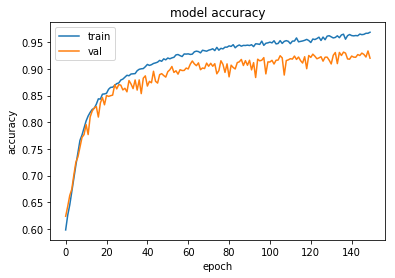

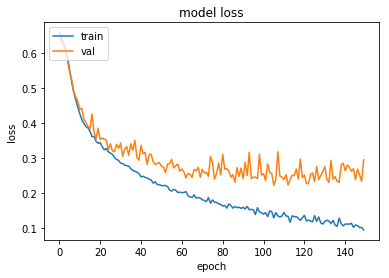

In [12]:
new_model = Sequential()
new_model.add(Dense(56, activation='relu', kernel_initializer='random_normal',input_dim = 28))
new_model.add(Dense(28,activation='relu', kernel_initializer='random_normal'))
new_model.add(Dense(14,activation='relu', kernel_initializer='random_normal'))
new_model.add(Dense(4,activation='relu', kernel_initializer='random_normal'))
new_model.add(Dense(1,activation='sigmoid', kernel_initializer='random_normal'))
new_model.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy',precision,recall])
print("Train------")
history = new_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=150, batch_size=32)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

In [16]:
print("Test-------")
new_model.evaluate(X_test, y_test)
loss_test, accuracy_test, precision, recall = new_model.evaluate(X_test, y_test)
print('test loss: ', loss_test)
print('test accuracy: ', accuracy_test)
print('test precision: ', precision)
print('test recall: ', recall)

Test-------
4996/4996 [==============================] - 0s 13us/step
test loss:  1.0350848099170589
test accuracy:  0.8414731621742249
test precision:  0.0573248416185379
test recall:  0.01182724442332983


              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4715
           1       0.08      0.17      0.11       281

   micro avg       0.84      0.84      0.84      4996
   macro avg       0.51      0.52      0.51      4996
weighted avg       0.90      0.84      0.87      4996



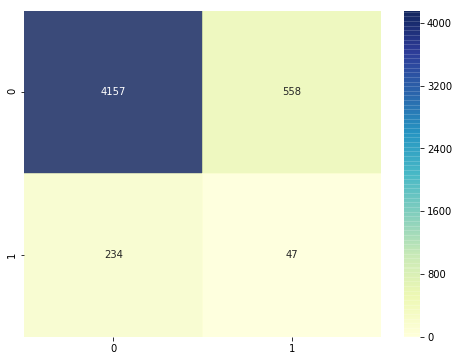

In [17]:
y_pred = new_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(new_model, X_test, y_test)